# Gantry sphrical scan

Author: Blair Jamieson
Date: December 2023

## Gantry coordinates.

The long axis of the gantry is $x$, the other horizontal axis is $y$, and the vertical axis is $z'$.  Note that the gantry motion in $x$ and $y$ are correct, while the motion in $z$ starts at $z=z'=0$ and as the gantry $z'$ coordinate is increased $z=-z'$.

The end of the gantry's $xyz$ motion is at $\vec{r}_g$ and the location of the calibration target $\vec{r}_t'$ relative to that position depends on the rotation in the $xy$-plane $\phi_g$, and the rotation relative to the $z$ axis $\theta_g$.

$$ \vec{r}_t' = 20\ \rm{cm}\ ( \sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$

The location of the target in gantry coordinates is:

$$ \vec{r}_t = \vec{r}_g + \vec{r}_t' $$

$$ \vec{r}_t = (x_g + 20\ \rm{cm}\ \sin{\phi_g})\hat{i} + (y_g + 20\ \rm{cm}\  \cos{\phi_g})\hat{j} - z_g'\hat{k}$$

The pointing of the calibration target (normal to the checkerboard pattern) is $\hat{n}_t$.  Note that the angle $\theta_g$ is the true spherical coordinates angle from the $z$-axis, but $\phi_g$ is measured going positive going counter-clockwise from the $y$-axis.  Therefore the true spherical coordinate $\phi = 90^{\circ} - \phi_g$.  The normal to the calibration target is:

$$\hat{n}_t = \sin{\theta_g}\cos{\phi_g}\hat{i} - \sin{\theta_g}\sin{\phi_g}\hat{j} + \cos{\theta_g}\hat{k}$$

In the gantry coordinates we define the camera position $\vec{r}_c$ and its facing $\hat{n}_c$.

## Scan semi-sphere around camera

Suppose we want to scan a semi-spherical plane around the camera.  How do we equally space the points on the surface of the sphere?  See for example https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf

The basic idea is to keep the solid angle between points constant, where

$$dA = r^2 \sin{\theta} d\theta d\phi= r d(r\cos{\theta}) d\phi = rdzd\phi$$

Choose circles of latitude at constant intervals $d_{\theta}$, and on each circle space points by distance $d_{\phi}$ such that $d_{\theta}\sim d_{\phi}$.  Suppose we want $N$ points in total.  Then:

```
dA = 4 * pi / N # as solid angle
d = sqrt( dA )
Mtheta = round( pi / d )
dtheta = pi / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = pi * ( m + 0.5 ) * m / Mtheta
    Mphi = round( 2*pi*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = 2 * pi * n / Mphi
        rcvec = r * [ sin( theta )*cos(phi), 
                       sin( theat )*sin(phi),
                       cos( theta ) ]
```

Now lets consider that we don't want to scan a full sphere, since we are limited to some range of coordinates in the gantry.  Instead, lets pick a number of scan points $N$ as before, and then start and end points in $\theta$ and $\phi$.  Eg. five parameters for the scan are specified: $(N,\theta_{1},\theta_{2}, \phi_{1}, \phi_{2})$, where the ranges are chosen to allow the points in the scan to be possible for the gantry to accomplish.  

The cross sectional area covered is no longer $4\pi$, but is:

$$ dA = \Delta \phi ( \cos{ \theta_{1} } - \cos{ \theta_{2}} )$$
$$\Delta \phi = \phi_{2} - \phi_{1}$$

The updated code becomes:

```
dA = (phi2-phi1) * ( cos(theta1) - cos(theta2) ) / N
d = sqrt( dA )
Mtheta = round( (theta2 - theta1) / d )
dtheta = (theta2 - theta1) / Mtheta
dphi = dA / dtheta
for m in range(Mtheta):
    theta = theta1 + (theta2-theta1) * ( m + 0.5 ) * m / Mtheta
    Mphi = round( (phi2-phi1)*sin(theta) / d_theta )
    for n in range(Mphi):
        phi = phi1 +  (phi2-phi1) * n / Mphi
        rcvec = rc * [ sin( theta )*cos(phi), 
                       sin( theat )*sin(phi),
                       cos( theta ) ]
```


## Rotate from camera coords to gantry coords

In the camera coordinates, define the scan point a distance $r$ from the camera as $\vec{r'}$, and in gantry coordinates the normal to the camera as $\hat{n}$.  To keep things simple, lets assume the camera coordinate $z$-axis is the same as the gantry coordinate $z$-axis, then the rotation is just in the plane. ie. $\vec{n}$.  The angle $\phi'$ in the gantry coordinates then depends on the angle $\phi'$ between the normal and the gantry x-axis:

$$ \phi' = {\rm arctan2}{( n_y, n_x )}$$



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class camera:
    def __init__(self, rc, nc):
        '''
        Define a camera, located at vector rc (a 3-vector) in gantry coordinates
        with facing nc (a 3-vector) normal vector for the camera facing.
        '''
        self.rc = rc
        self.nc = nc
        self.phip = np.arctan2( nc[1], nc[0] )
        print('camera phi=',self.phip)
        
    def get_scanpoints( self, N, r, phi1, phi2, theta1, theta2  ):
        '''
        Inputs: 
        N = number of scan points
        r = distance from camera to place target
        phi1, phi2 = range in phi measured from camera point of view
        theta1, theta2 = range in polar angle theta
        Angles are in ** radians **
        
        Return a list of position vectors.
        
        rcamera = a list of approximately N points in global coordinate
                  system of the vector from the camera to the target
        '''
        assert( N > 0 )
        assert( r > 0 )
        assert( phi2 > phi1 )
        assert( theta2 > theta1 )
        rvecs = []
        dA = (phi2-phi1) * ( np.cos(theta1) - np.cos(theta2) ) / N
        d = np.sqrt( dA )
        Mtheta = int( np.rint( (theta2 - theta1) / d ) )
        dtheta = (theta2 - theta1) / Mtheta
        dphi = dA / dtheta
        for m in range(Mtheta):
            theta = theta1 + (theta2-theta1) * ( m + 0.5 ) / Mtheta
            Mphi = int( np.abs(np.rint( (phi2-phi1)*np.sin(theta) / dtheta )) )
            for n in range(Mphi):
                dphi= (phi2-phi1)* (n+0.5) / Mphi
                phi= phi1 + dphi
                #handle raster in phi
                if m % 2 == 1: #go down in phi
                    phi = phi2 - dphi
                # rotate from camera phi to gantry phi!
                phi += self.phip
                rcvec =  [ r*np.sin( theta ) * np.cos(phi), 
                              r*np.sin( theta ) * np.sin(phi),
                              r*np.cos( theta ) ]
                rvecs.append( np.array(rcvec) )
        return rvecs

In [14]:
# Test the code
# camera positioned at [800,400,-600] cm pointing in -y direction
c1 = camera( [800.0,400.0,-600.0], [0.,-1.,0])
deg2rad = np.pi/180.0
scanpts = c1.get_scanpoints(N=100,r=400, 
                            phi1=-70.*deg2rad, phi2=70*deg2rad,
                            theta1=20.0*deg2rad, theta2=90.0*deg2rad)
npscanpts=np.array(scanpts)

camera phi= -1.5707963267948966


Text(0.5, 0.92, 'Pos relative to camera')

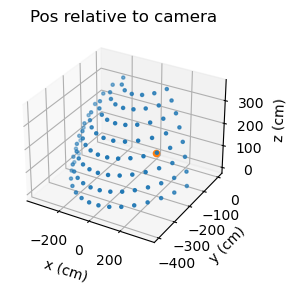

In [15]:
X=npscanpts.T[0]
Y=npscanpts.T[1]
Z=npscanpts.T[2]
fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.scatter(X,Y,Z,marker='.')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')
ax.scatter(0.,0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

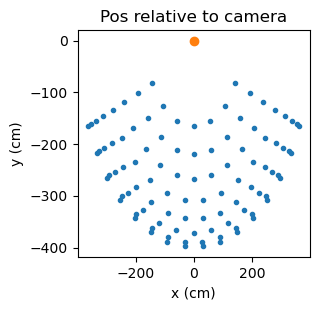

In [16]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(X,Y,'.')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

Text(0.5, 1.0, 'Pos relative to camera')

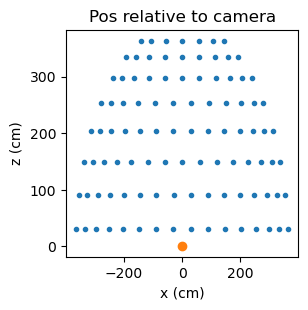

In [17]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(X,Z,'.')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.plot(0.,0.,'o')
plt.title('Pos relative to camera')

## Now calculate position and rotation of gantry

Now that we have a list of camera vectors $\vec{r}$ in gantry coordinates, we want to calculate the vector $\vec{r}_g$, $\theta_g$, and $\phi_g$ (the x,y,z of the gantry and its rotation).  This position is such that:

$$\vec{r}_g+\vec{r}_t = \vec{r}_c + \vec{r}$$

$$\vec{r}_g = \vec{r}_c + \vec{r} - \vec{r}_t$$

The vector $\vec{r}$ and $\vec{r}_c$ we get from the camera.  The vector $\vec{r}_t$ depends on the normal vector of $-\vec{r}$ (the target facing $\hat{n_t}$).  We find:

$$ \hat{n_t} = -\frac{\vec{r}}{r} $$
$$ \phi = \rm{arctan2}( n[1] , n[0] )$$
$$ \theta = \rm{arcsin}\left( \sqrt{ 1 - n[2]^2 } \right)$$

The gantry facing is then $\phi_g=90-\phi$ and $\theta_g=\theta$.  The gantry target vector is:

$$ \vec{r}_t' = 20\ \rm{cm}\ ( \sin{\phi_g} \hat{i} + \cos{\phi_g} \hat{j} ) $$



In [21]:
def get_gantry_setting( r, rc ):
    '''
    Given desired target position r relative to the camera posiiton at rc, 
    return the gantry settings (rg,phig,thetag) and 
    the target location (rt,nt).
    '''
    nt = -r / np.linalg.norm(r)
    phi = np.arctan2( nt[1], nt[0] )
    theta = np.arcsin( np.sqrt(1-nt[2]**2) )
    phig = np.pi/2 - phi
    thetag = theta
    rt = np.array( [20 * np.sin(phig), 20 * np.cos(phig), 0 ] )
    rg = rc + r - rt
    #print('rg=',rg,'rc=',rc,'r=',r,'rt=',rt)
    return (rg, phig, thetag, rt,nt) 



In [22]:
def get_gantry_settings( cam, rvecs ):
    '''
    Given a vector of scan points in rvecs, get a list of gantry settings.
    
    Inputs:
    cam = camera object
    rvecs = list of 3-vectors pointing from camera to target
    
    Returns:
    gsettings  = list of gantry settings (xg,yg,zg,phig,thetag) in cm and rad
    tlocs     = list of target positions (xt,yt,zt,ntx,nty,ntz) in cm and normal vector
    '''
    gsettings = []
    tlocs = []
    for rv in rvecs:
        rg, phig, thetag, rt, nt = get_gantry_setting( rv, cam.rc )
        gsettings.append( [rg[0],rg[1],rg[2],phig,thetag] )
        tlocs.append( [rt[0],rt[1],rt[2],nt[0],nt[1],nt[2]] )
    return (gsettings, tlocs)
                           

In [23]:
gsets, tls = get_gantry_settings( c1, scanpts )

Text(0.5, 0.92, 'Gantry position')

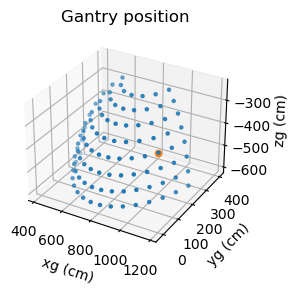

In [24]:

npgsets = np.array(gsets)
GX = npgsets.T[0]
GY = npgsets.T[1]
GZ = npgsets.T[2]

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.scatter(GX,GY,GZ,marker='.')
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o')
#ax.set_xlim([0,2000.])
#ax.set_ylim([0,2000.])
#ax.set_zlim([-1000,1000.])
ax.set_xlabel('xg (cm)')
ax.set_ylabel('yg (cm)')
ax.set_zlabel('zg (cm)')
ax.set_title('Gantry position')

Text(0.5, 1.0, 'gantry position')

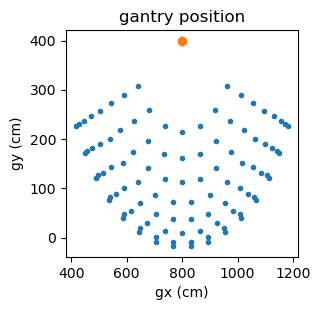

In [25]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX,GY,'.')
plt.plot( c1.rc[0], c1.rc[1],  marker='o')
plt.xlabel('gx (cm)')
plt.ylabel('gy (cm)')
plt.title('gantry position')

Text(0.5, 1.0, 'gantry position')

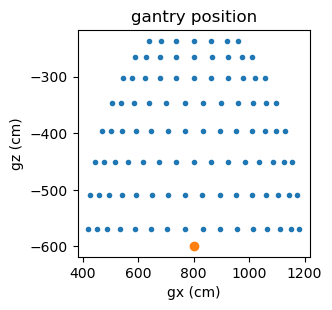

In [26]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX,GZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gx (cm)')
plt.ylabel('gz (cm)')
plt.title('gantry position')

Text(0.5, 0.92, 'Target position and pointing')

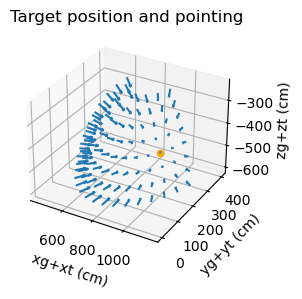

In [27]:
nptls = np.array(tls)
TX = nptls.T[0]
TY = nptls.T[1]
TZ = nptls.T[2]

NX = nptls.T[3]
NY = nptls.T[4]
NZ = nptls.T[5]

fig=plt.figure(figsize=(3,3),dpi=100)
ax = fig.add_subplot(projection='3d')
ax.quiver(GX+TX,GY+TY,GZ+TZ,NX,NY,NZ,length=50.0)
ax.scatter( c1.rc[0], c1.rc[1], c1.rc[2], marker='o', color='orange')

ax.set_xlabel('xg+xt (cm)')
ax.set_ylabel('yg+yt (cm)')
ax.set_zlabel('zg+zt (cm)')
ax.set_title('Target position and pointing')

Text(0.5, 1.0, 'target position')

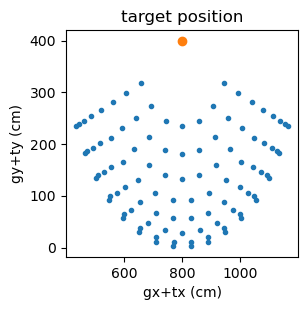

In [28]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GY+TY,'.')
plt.plot( c1.rc[0], c1.rc[1],  marker='o')
plt.xlabel('gx+tx (cm)')
plt.ylabel('gy+ty (cm)')
plt.title('target position')

Text(0.5, 1.0, 'target position')

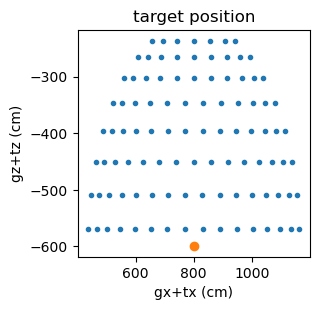

In [29]:
plt.figure(figsize=(3,3),dpi=100)
plt.plot(GX+TX,GZ+TZ,'.')
plt.plot( c1.rc[0], c1.rc[2],  marker='o')
plt.xlabel('gx+tx (cm)')
plt.ylabel('gz+tz (cm)')
plt.title('target position')